# Asset Level Carbon Intensity Estimation

<br>

### Imports

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import FEAutils as hlp

<br>

### Data Preparation

We'll start by loading in the attribute data from the Power Station Dictionary

In [2]:
attributes_fp = 'https://osuked.github.io/Power-Station-Dictionary/object_attrs/dictionary_attributes.csv'

df_attrs = pd.read_csv(attributes_fp)

df_attrs.head()

,attribute,id,value,datapackage,id_type,year,dictionary_id,financial_year
0,Fuel Type,MARK-1,BIOMASS,https://raw.githubusercontent.com/OSUKED/Dicti...,ngc_bmu_id,NaN,10000,NaN
1,Longitude,10000,-3.603516,https://raw.githubusercontent.com/OSUKED/Dicti...,osuked_id,NaN,10000,NaN
2,Latitude,10000,57.480403,https://raw.githubusercontent.com/OSUKED/Dicti...,osuked_id,NaN,10000,NaN
3,Annual Output (MWh),MARK-1,355704.933,https://raw.githubusercontent.com/OSUKED/Dicti...,ngc_bmu_id,2016.0,10000,NaN
4,Annual Output (MWh),MARK-1,387311.364,https://raw.githubusercontent.com/OSUKED/Dicti...,ngc_bmu_id,2017.0,10000,NaN


In [3]:
ids_fp = 'https://raw.githubusercontent.com/OSUKED/Power-Station-Dictionary/shiro/data/dictionary/ids.csv'

df_ids = pd.read_csv(ids_fp).set_index('osuked_id')

df_ids.head(2)

,gppd_idnr,esail_id,name,sett_bmu_id,ngc_bmu_id,4c_offshore_id,windpowernet_id,wikidata_id,wikipedia_id,power_technology_id,eutl_id,eic_id,cfd_id,jrc_id,iaea_id,old_repd_id,new_repd_id
osuked_id,,,,,,,,,,,,,,,,,
10000,NaN,MARK,Rothes Bio-Plant CHP,"E_MARK-1, E_MARK-2","MARK-1, MARK-2",NaN,NaN,NaN,NaN,NaN,NaN,48W000000MARK-1D,NaN,NaN,NaN,NaN,NaN
10001,"GBR1000377, GBR1000369",DIDC,Didcot,"T_DIDC1, T_DIDC2, T_DIDC4, T_DIDC3, T_DIDC1G, ...","DIDC1, DIDC2, DIDC4, DIDC3, DIDC1G, DIDC2G, DI...",NaN,NaN,NaN,NaN,NaN,97165,"48W00000DIDC01G1, 48W00000DIDC02GZ, 48W00000DI...",NaN,NaN,NaN,NaN,NaN


<br>

We'll then extract the CO2 emissions data

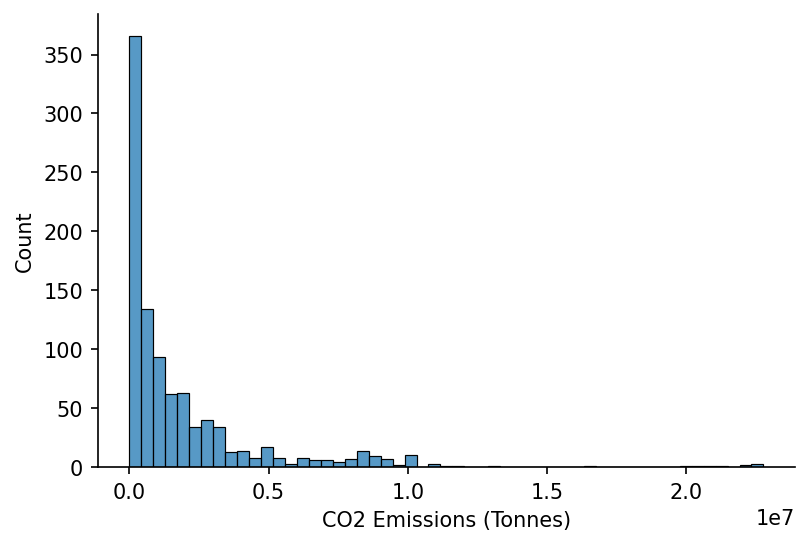

In [4]:
co2_attr = 'CO2 Emissions (Tonnes)'

s_site_co2 = (
    df_attrs
    .query('attribute==@co2_attr')
    [['dictionary_id', 'year', 'value']]
    .dropna()
    .astype({'dictionary_id': int, 'year': int, 'value': float})
    .groupby(['dictionary_id', 'year'])
    ['value']
    .sum()
)

# Plotting
fig, ax = plt.subplots(dpi=150)

sns.histplot(s_site_co2, ax=ax)

ax.set_xlabel(co2_attr)
hlp.hide_spines(ax)

<br>

As well as the power output data

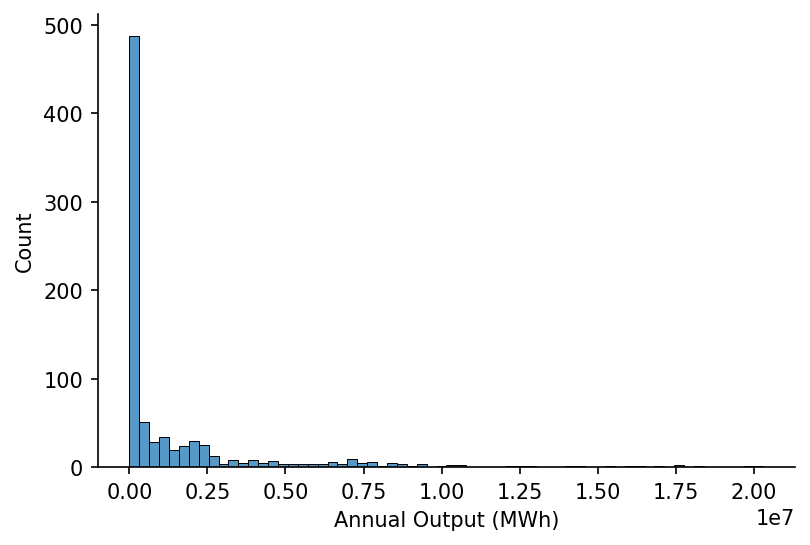

In [5]:
output_attr = 'Annual Output (MWh)'

s_site_output = (
    df_attrs
    .query('attribute==@output_attr')
    [['dictionary_id', 'year', 'value']]
    .dropna()
    .astype({'dictionary_id': int, 'year': int, 'value': float})
    .groupby(['dictionary_id', 'year'])
    ['value']
    .sum()
)

# Plotting
fig, ax = plt.subplots(dpi=150)

sns.histplot(s_site_output, ax=ax)

ax.set_xlabel(output_attr)
hlp.hide_spines(ax)

<br>

And lastly the fuel types of each plant

In [6]:
fuel_attr = 'Fuel Type'

s_site_fuel_type = (
    df_attrs
    .query('attribute==@fuel_attr')
    [['dictionary_id', 'value']]
    .dropna()
    .astype({'dictionary_id': int, 'value': str})
    .groupby('dictionary_id')
    ['value']
    .agg(lambda fuel_types: ', '.join(set(fuel_types)))
)

s_site_fuel_type.value_counts()

WIND                   112
CCGT                    34
NPSHYD                  13
NUCLEAR                  7
PS                       4
OCGT                     4
CCGT, OCGT               3
BIOMASS                  3
COAL, OCGT               1
CCGT, COAL, OCGT         1
Wind                     1
OTHER                    1
COAL, BIOMASS, OCGT      1
Name: value, dtype: int64

In [71]:
manual_fuel_matches = {
    10000: 'biomass', # with CHP
    10002: 'coal', # co-firing with biomass
    10003: 'coal',
    10005: 'coal',
    10006: 'coal',
    10007: 'coal',
    10009: 'coal',
    10012: 'coal',
    10015: 'coal',
    10018: 'biomass', # ran 100% biomass after 2015
    10050: 'bess, ccgt', # coal before then ccgt since 1991 (now has a battery on the site since 2018)
    10019: 'coal', # with oil
    10020: 'coal, biomass',
    10082: 'oil',
    10022: 'ccgt',
    10024: 'ocgt', # started running open-cycle after 2012
    10088: 'recip',
    10089: 'recip',
    10028: 'ccgt',
    10060: 'ocgt', # ccgts were shut down in 2011 (ocgts were too in 2015)
    10061: 'ccgt',
    10064: 'ccgt',
    10037: 'ccgt',
    10139: 'nuclear',
    10071: 'ccgt', # with CHP
    10141: 'coal', # with oil
    10083: 'diesel', # with CHP
    10078: 'recip',
    10198: 'wind'
}

s_site_fuel_type_mod = s_site_fuel_type.copy().append(pd.Series(manual_fuel_matches))
s_site_fuel_type_mod[s_site_fuel_type_mod.str.contains(', ')] = 'MIXED'
s_site_fuel_type_mod = s_site_fuel_type_mod.str.lower()

s_site_fuel_type_mod.value_counts()

wind       114
ccgt        40
npshyd      13
coal        10
mixed        8
nuclear      8
ocgt         6
biomass      5
ps           4
recip        3
diesel       1
oil          1
other        1
dtype: int64

<br>

### Data Coverage

We'll start by getting the ids of the plants in each dataset

In [72]:
sites_with_co2_data = s_site_co2.index.get_level_values(0).unique()
sites_with_output_data = s_site_output.index.get_level_values(0).unique()
sites_with_fuel_type_data =s_site_fuel_type_mod.index

sites_with_all_datasets = sites_with_co2_data.intersection(sites_with_output_data).intersection(sites_with_fuel_type_data)

dataset_ids = {
    'emissions': sites_with_co2_data, 
    'power output': sites_with_output_data, 
    'fuel type': sites_with_fuel_type_data, 
    'all': sites_with_all_datasets
}

print('Data Coverage\n=================')
for dataset, ids in dataset_ids.items():
    print(f'{dataset.capitalize()}: {ids.size}')

Data Coverage
Emissions: 73
Power output: 165
Fuel type: 214
All: 54


<br>

We'll first identify plants that have associated emissions but no assigned fuel type

In [73]:
relevant_fuel_types = ['coal', 'ccgt', 'ocgt', 'biomass', 'mixed', 'recip', 'oil']

sites_with_relevant_fuel_type = s_site_fuel_type_mod.index[s_site_fuel_type_mod.isin(relevant_fuel_types)]
sites_without_relevant_fuel_type = s_site_fuel_type_mod.index[~s_site_fuel_type_mod.isin(relevant_fuel_types)]
sites_with_emissions_but_no_fuel_type = sites_with_co2_data[~sites_with_co2_data.isin(sites_with_relevant_fuel_type)]

df_ids.loc[sites_with_emissions_but_no_fuel_type, 'name']

dictionary_id
10072    Shotton CHP
10074      Stoke CHP
Name: name, dtype: object

<br>

We'll also filter for any sites for which we have output data but not emissions data (excluding RES plants and those which have already been identified as having emissions but no fuel type)

In [74]:
output_datasets_to_match = sorted(list(set(sites_with_output_data) - set(sites_with_all_datasets) - set(sites_with_emissions_but_no_fuel_type) - set(sites_without_relevant_fuel_type)))

df_ids.loc[output_datasets_to_match, 'name']

osuked_id
10000    Rothes Bio-Plant CHP
Name: name, dtype: object

<br>

### Calculating Annual Carbon Intensities

We're now ready to calculate the annual carbon intensities

In [75]:
s_site_carbon_intensity = 1000 * (s_site_co2.loc[sites_with_all_datasets]/s_site_output.loc[sites_with_all_datasets]).replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()

s_site_carbon_intensity

dictionary_id  year
10002          2016     856.556931
               2017     849.483513
               2018     933.703289
               2019     918.491921
               2020    3368.789243
                          ...     
10104          2016    1104.226297
               2017    1110.856183
               2018    1103.122391
               2019    1125.497186
               2020    1070.007876
Name: value, Length: 236, dtype: float64

<br>

We'll now filter for only thermal generation

In [76]:
s_site_focus_carbon_intensity = s_site_carbon_intensity.loc[s_site_carbon_intensity.index.get_level_values(0).isin(sites_with_all_datasets)]
s_site_focus_fuel_types = pd.Series(s_site_focus_carbon_intensity.index.get_level_values(0).map(s_site_fuel_type_mod.to_dict()), index=s_site_focus_carbon_intensity.index)

s_site_focus_carbon_intensity

dictionary_id  year
10002          2016     856.556931
               2017     849.483513
               2018     933.703289
               2019     918.491921
               2020    3368.789243
                          ...     
10104          2016    1104.226297
               2017    1110.856183
               2018    1103.122391
               2019    1125.497186
               2020    1070.007876
Name: value, Length: 236, dtype: float64

<br>

We'll also check if there's any outliers which haven't been evaluated

In [121]:
assert s_site_focus_carbon_intensity.index[s_site_focus_carbon_intensity<0].size == 0, 'There should not be sites with negative carbon intensities'

known_carbon_intensity_outliers = [
    (10002, 2020), # the site shut-down
    (10013, 2018), # low output whilst converting to biomass
    (10013, 2019), # low output whilst converting to biomass
    (10024, 2018), # low output whilst closing
    (10024, 2019), # low output whilst closing
    (10026, 2018), # output fell whilst emissions rose - perhaps due to adjacent biomass plant which is not included in output but is in emissions
    (10026, 2019), # output fell whilst emissions rose - perhaps due to adjacent biomass plant which is not included in output but is in emissions
    (10026, 2020), # output fell whilst emissions rose - perhaps due to adjacent biomass plant which is not included in output but is in emissions
    (10048, 2018), # 5 recips started generating at the end of 2018 (which are likely not included in output)
    (10048, 2019), # 5 recips started generating at the end of 2018 (which are likely not included in output)
    (10048, 2020), # 5 recips started generating at the end of 2018 (which are likely not included in output)
    (10066, 2016), # located in sellafield, probably including emissions unrelated to electricity generation
    (10066, 2017), # located in sellafield, probably including emissions unrelated to electricity generation
    (10066, 2018), # located in sellafield, probably including emissions unrelated to electricity generation
    (10066, 2019), # located in sellafield, probably including emissions unrelated to electricity generation
    (10066, 2020), # located in sellafield, probably including emissions unrelated to electricity generation
    (10091, 2020), # unclear 
    (10097, 2020), # unclear
    (10065, 2016), # the emissions site boundary is fuzzy as it is located within an oil refinery
    (10065, 2017), # the emissions site boundary is fuzzy as it is located within an oil refinery
    (10065, 2018), # the emissions site boundary is fuzzy as it is located within an oil refinery
    (10065, 2019), # the emissions site boundary is fuzzy as it is located within an oil refinery
    (10065, 2020), # the emissions site boundary is fuzzy as it is located within an oil refinery
]

s_outlier_carbon_intensities = s_site_focus_carbon_intensity.loc[s_site_focus_carbon_intensity.index[s_site_focus_carbon_intensity>1200]]
outlier_carbon_intensity_sites = s_outlier_carbon_intensities.index.get_level_values(0).unique()

unknown_carbon_intensity_outliers = s_outlier_carbon_intensities.drop(set(known_carbon_intensity_outliers).intersection(set(s_outlier_carbon_intensities.index))).index
unknown_carbon_intensity_outliers.size

0

<br>

Finally we're ready to save the dataset

In [189]:
s_site_focus_carbon_intensity.name = 'carbon_intensity_gco2_per_kwh'
s_site_focus_carbon_intensity = s_site_focus_carbon_intensity.drop(set(known_carbon_intensity_outliers).intersection(set(s_site_focus_carbon_intensity.index)))

s_site_focus_carbon_intensity.to_csv('../data/plant_carbon_intensity.csv', float_format='%.2f')

<br>

### Visualisations

Our first visualisation will be a scatter plot of carbon intensity against annual emissions

Text(0, 0.5, 'Annual Carbon Intensity (gCO2/kWh)')

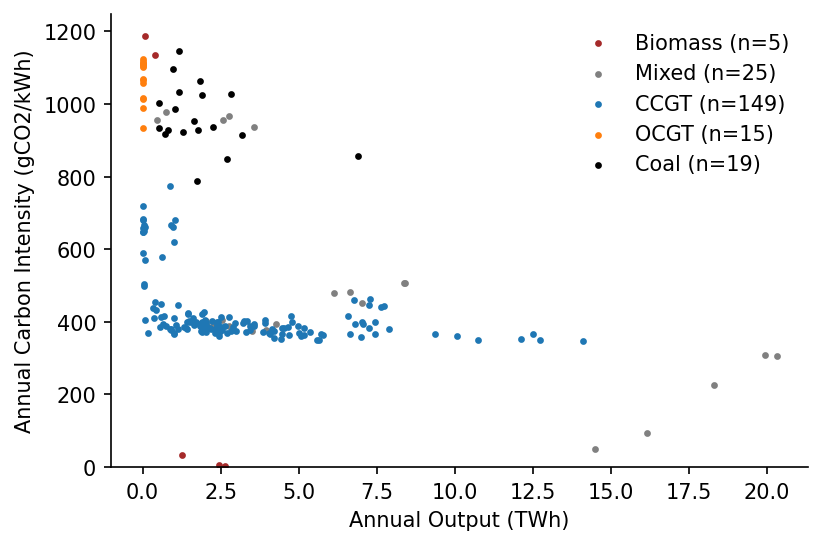

In [131]:
fuel_colour_map = {
    'Biomass': 'brown', 
    'Mixed': 'grey', 
    'CCGT': 'C0', 
    'OCGT': 'C1',
    'Coal': 'black',
    'RGT': 'purple'
}

# Plotting
fig, ax = plt.subplots(dpi=150)

for fuel_type in fuel_colour_map.keys():
    idxs = s_site_focus_carbon_intensity.index[s_site_focus_carbon_intensity.index.get_level_values(0).isin(s_site_fuel_type_mod.index[s_site_fuel_type_mod==fuel_type.lower()])]
    
    if idxs.size > 0:
        ax.scatter(s_site_output.loc[idxs].divide(1e6), s_site_focus_carbon_intensity.loc[idxs], c=fuel_colour_map[fuel_type], label=f'{fuel_type} (n={idxs.size})', s=5)

hlp.hide_spines(ax)
ax.set_ylim(0)
ax.legend(frameon=False)
ax.set_xlabel('Annual Output (TWh)')
ax.set_ylabel('Annual Carbon Intensity (gCO2/kWh)')

Text(0, 0.5, 'Annual Carbon Intensity (gCO2/kWh)')

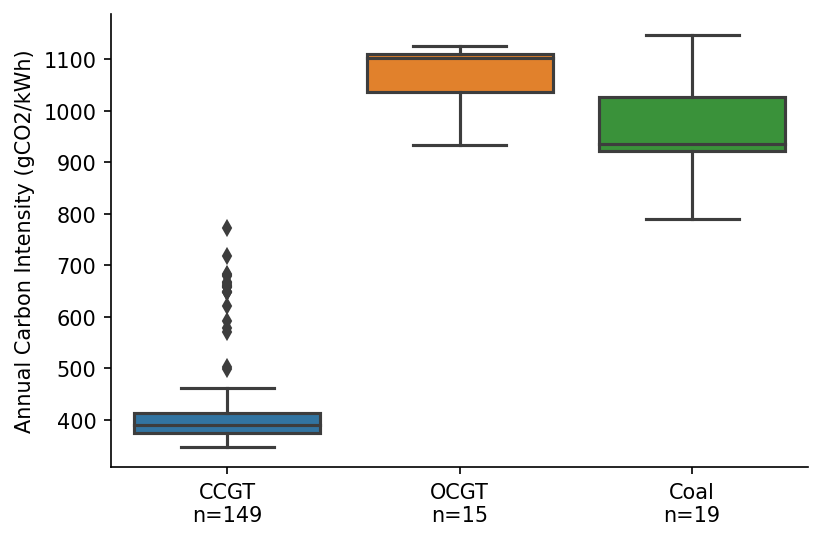

In [166]:
s_plot_fuel_types = s_site_focus_fuel_types.loc[s_site_focus_carbon_intensity.index][s_site_focus_fuel_types.loc[s_site_focus_carbon_intensity.index].isin(['coal', 'ocgt', 'ccgt'])].drop(set(known_carbon_intensity_outliers).intersection(set(s_site_focus_carbon_intensity.index)))

fuel_label_map = {
    'ccgt': f'CCGT\nn={s_plot_fuel_types.value_counts()["ccgt"]}', 
    'ocgt': f'OCGT\nn={s_plot_fuel_types.value_counts()["ocgt"]}',
    'coal': f'Coal\nn={s_plot_fuel_types.value_counts()["coal"]}'
}

# Plotting
fig, ax = plt.subplots(dpi=150)

sns.boxplot(y=s_site_focus_carbon_intensity.loc[s_plot_fuel_types.index], x=s_plot_fuel_types.map(fuel_label_map), orient='v', ax=ax, order=fuel_label_map.values())

hlp.hide_spines(ax)
ax.set_xlabel('')
ax.set_ylabel('Annual Carbon Intensity (gCO2/kWh)')

In [177]:
df_avg_carbon_intensities = pd.DataFrame(index=fuel_label_map.keys(), columns=['average', 'median'])
df_avg_carbon_intensities.index.name = 'fuel_type'

for fuel_type in df_avg_carbon_intensities.index:
    fuel_idxs = s_plot_fuel_types.index[s_plot_fuel_types==fuel_type]
    
    df_avg_carbon_intensities.loc[fuel_type, 'average'] = np.average(s_site_focus_carbon_intensity.loc[fuel_idxs], weights=s_site_output.loc[fuel_idxs])
    df_avg_carbon_intensities.loc[fuel_type, 'median'] = s_site_focus_carbon_intensity.loc[fuel_idxs].median()
    
df_avg_carbon_intensities

,average,median
fuel_type,,
ccgt,387.471,389.257
ocgt,1071.05,1103.12
coal,940.148,935.907


<br>

And then create a histogram for only the OCGT and CCGT plants 

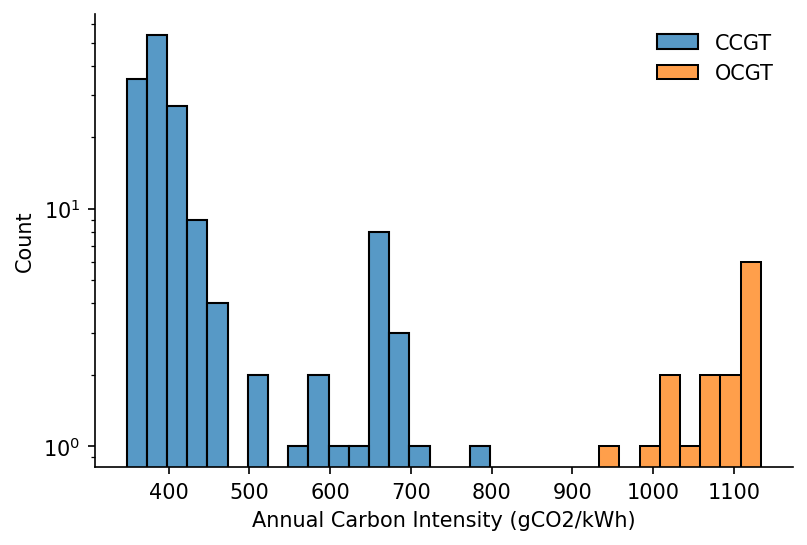

In [188]:
fig, ax = plt.subplots(dpi=150)

for i, fuel_type in enumerate(['ccgt', 'ocgt']):
    fuel_idxs = s_plot_fuel_types.index[s_plot_fuel_types==fuel_type]
    sns.histplot(s_site_focus_carbon_intensity.loc[fuel_idxs], binwidth=25, ax=ax, label=fuel_type.upper(), color=f'C{i}')

ax.set_xlabel('Annual Carbon Intensity (gCO2/kWh)')
hlp.hide_spines(ax)
ax.set_yscale('log')
ax.legend(frameon=False)